In [5]:
import re
from pathlib import Path

import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import pandas as pd

In [6]:
CPU_FREQ_FILE = 'cpu.csv'
CPU_UTILIZATION_FILE = 'cpu_utilization.csv'
MEM_UTILIZATION_FILE = 'memory.csv'
STEPS_FILE = 'steps.csv'

steps_df = pd.read_csv(STEPS_FILE)
steps_df['timestamp'] = pd.to_datetime(steps_df['timestamp'])


def merge_with_steps(file):
    # Load CSV files into dataframes
    cpu_df = pd.read_csv(file)
    # Convert 'Timestamp' columns to datetime objects
    cpu_df['Timestamp'] = pd.to_datetime(cpu_df['Timestamp'])
    # Merge dataframes on the closest timestamp
    merged_df = pd.merge_asof(cpu_df, steps_df, left_on='Timestamp', right_on='timestamp', direction='backward')
    # Drop redundant timestamp column
    merged_df = merged_df.drop(columns='timestamp')
    # Fill NaN values in 'event' column with a placeholder value
    merged_df['event'] = merged_df['event'].fillna('N/A')
    # Display the merged dataframe
    return cpu_df, merged_df


In [7]:
def format_timedelta(td):
    total_seconds = int(td.total_seconds())
    hours, remainder = divmod(total_seconds, 3600)
    minutes, seconds = divmod(remainder, 60)
    return f"{hours}:{minutes}:{seconds:02}"


CONFIG = re.sub(r"run\.|\.cfg\.parsed", "", Path.cwd().name)
print(CONFIG)

# Create a list of labels and midpoints for the top x-axis
labels = []
midpoints = []
for index in range(0, len(steps_df), 2):
    step_start = steps_df.loc[index, 'timestamp']
    step_end = steps_df.loc[index + 1, 'timestamp'] if index < len(steps_df) - 1 else steps_df['Timestamp'].max()
    duration = step_end - step_start
    duration_str = format_timedelta(duration)
    midpoint = step_start + (step_end - step_start) / 2
    midpoints.append(midpoint)
    labels.append(f"{steps_df.loc[index, 'module']} ({duration_str})")


dpp-local-nc16_gl5-32


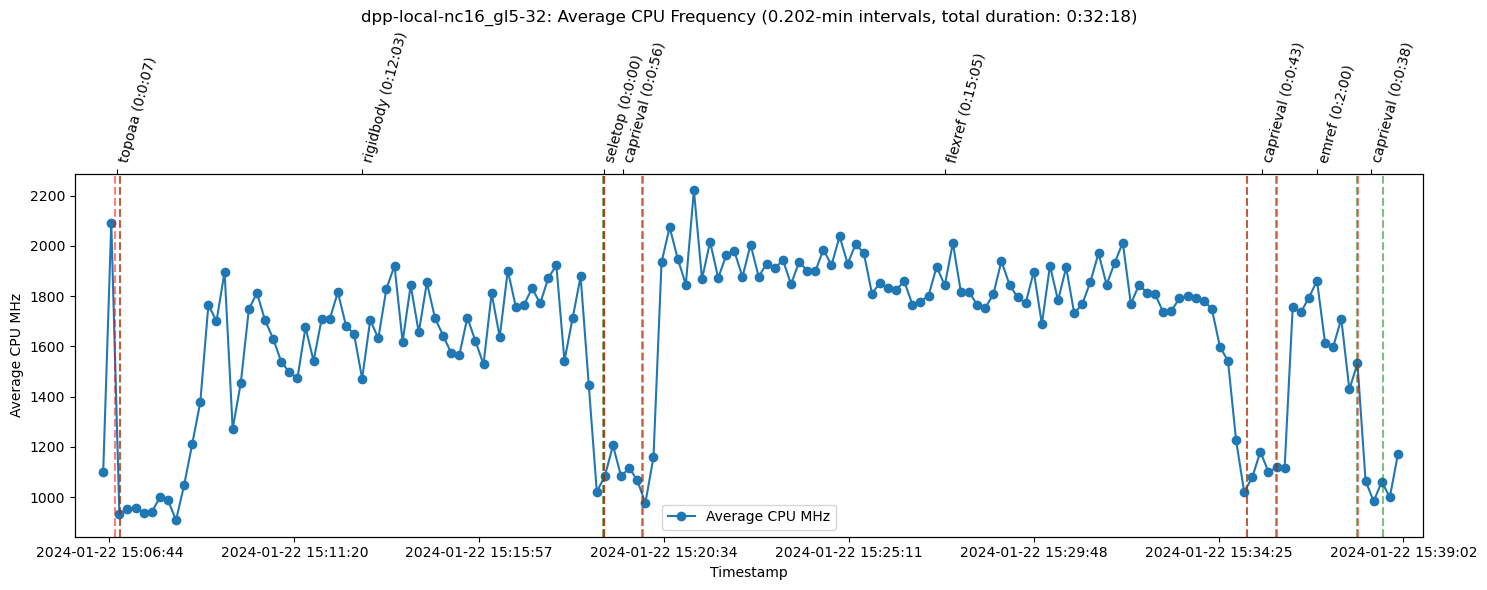

In [9]:
num_data_points = 160
num_ticks = 8

cpu_freq_df, cpu_freq_merged_df = merge_with_steps(CPU_FREQ_FILE)

field_name = 'CPU MHz'
data_df = cpu_freq_df
y_label = 'Average CPU MHz'
title = 'Average CPU Frequency'
png = "run_avg_cpu_freq.png"

# Calculate the total duration in minutes
duration_delta = data_df['Timestamp'].max() - data_df['Timestamp'].min()
total_duration = duration_delta.total_seconds() / 60

# Calculate the frequency in minutes
freq = round(total_duration / num_data_points, 3)

# Calculate average CPU MHz values in intervals based on the frequency
avg_freq = data_df.groupby(pd.Grouper(key='Timestamp', freq=f'{freq}Min'))[field_name].mean().reset_index()

# Plot average CPU frequency with colored data points according to steps
fig, ax1 = plt.subplots(figsize=(15, 6))

ax1.plot(avg_freq['Timestamp'], avg_freq[field_name], marker='o', linestyle='-',
         label=f'{y_label}')

# Set the second x-axis for steps
ax2 = ax1.twiny()

# Set the labels on the top x-axis
ax2.set_xticks(midpoints)
ax2.set_xticklabels(labels, rotation=75, fontsize=10, ha="left")

# Format the x-axis date ticks
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M:%S'))

# Set custom x-axis and y-axis ticks for better visualization
x_ticks = pd.date_range(start=data_df['Timestamp'].min(), end=data_df['Timestamp'].max(), periods=num_ticks)
x_ticks = x_ticks.union([data_df['Timestamp'].min()])
ax1.set_xticks(x_ticks)

# Trim the right and left part of the graph
ax1.set_xlim(
    [steps_df['timestamp'].min() - pd.Timedelta(minutes=1), steps_df['timestamp'].max() + pd.Timedelta(minutes=1)])
ax2.set_xlim(ax1.get_xlim())

# Add vertical lines
for index, row in steps_df.iterrows():
    if row.event == 'start':
        step_start = row['timestamp']
        ax1.axvline(x=step_start, color='r', linestyle='--', alpha=.5)  # Add vertical line at the start of each step
    else:
        step_end = row['timestamp']
        ax1.axvline(x=step_end, color='g', linestyle='--', alpha=.5)  # Add vertical line at the end of each step

# Set labels and title
ax1.set_xlabel('Timestamp')
ax1.set_ylabel(y_label)
ax1.legend()
plt.title(f"{CONFIG}: {title} ({freq}-min intervals, total duration: {format_timedelta(duration_delta)})")

# Show the plot
plt.tight_layout()
fig.savefig(png)

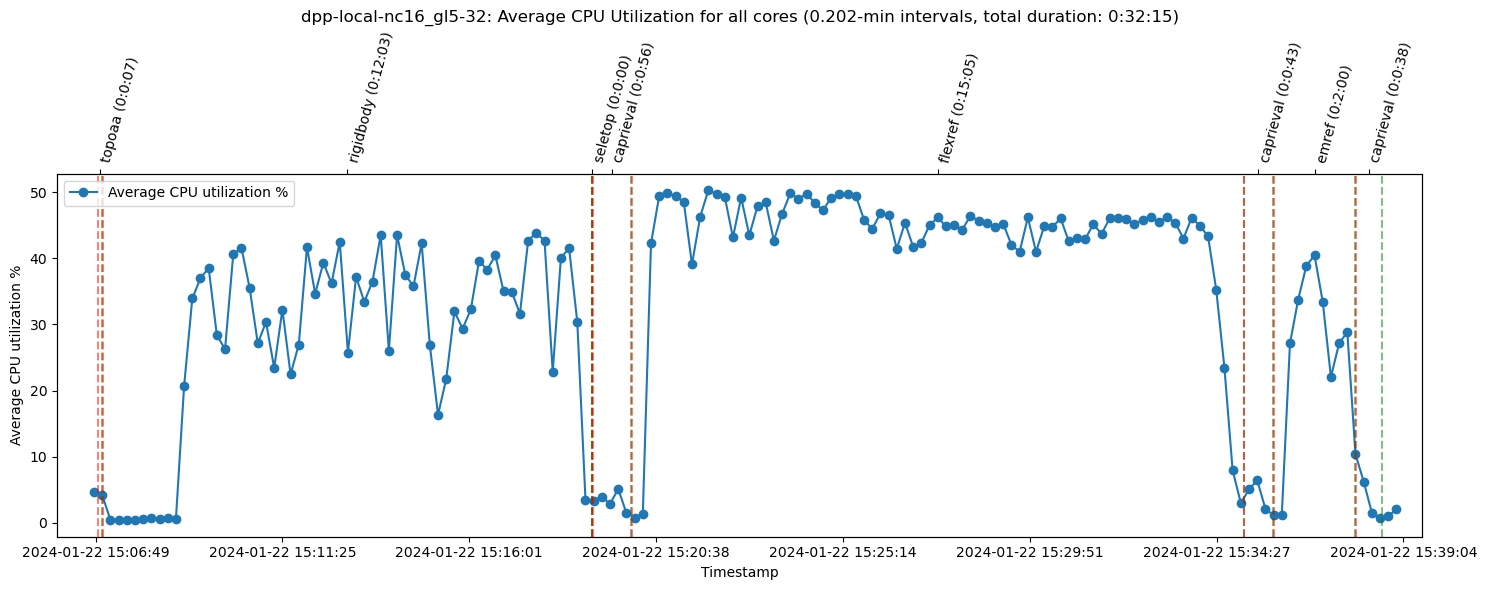

In [10]:
cpu_util_df, cpu_util_merged_df = merge_with_steps(CPU_UTILIZATION_FILE)

field_name = '%user_%system'

cpu_util_df[field_name] = cpu_util_df['%user'] + cpu_util_df['%system']
cpu_util_df_all = cpu_util_df[cpu_util_df['CPU'] == 'all']

data_df = cpu_util_df_all
y_label = 'Average CPU utilization %'
title = 'Average CPU Utilization for all cores'
png = "run_avg_cpu_util_all.png"

# Calculate the total duration in minutes
duration_delta = data_df['Timestamp'].max() - data_df['Timestamp'].min()
total_duration = duration_delta.total_seconds() / 60

# Calculate the frequency in minutes
freq = round(total_duration / num_data_points, 3)

# Calculate average CPU MHz values in intervals based on the frequency
avg_freq = data_df.groupby(pd.Grouper(key='Timestamp', freq=f'{freq}Min'))[field_name].mean().reset_index()

# Plot average CPU frequency with colored data points according to steps
fig, ax1 = plt.subplots(figsize=(15, 6))

ax1.plot(avg_freq['Timestamp'], avg_freq[field_name], marker='o', linestyle='-',
         label=f'{y_label}')

# Set the second x-axis for steps
ax2 = ax1.twiny()

# Set the labels on the top x-axis
ax2.set_xticks(midpoints)
ax2.set_xticklabels(labels, rotation=75, fontsize=10, ha="left")

# Format the x-axis date ticks
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M:%S'))

# Set custom x-axis and y-axis ticks for better visualization
x_ticks = pd.date_range(start=data_df['Timestamp'].min(), end=data_df['Timestamp'].max(), periods=num_ticks)
x_ticks = x_ticks.union([data_df['Timestamp'].min()])
ax1.set_xticks(x_ticks)

# Trim the right and left part of the graph
ax1.set_xlim(
    [steps_df['timestamp'].min() - pd.Timedelta(minutes=1), steps_df['timestamp'].max() + pd.Timedelta(minutes=1)])
ax2.set_xlim(ax1.get_xlim())

# Add vertical lines
for index, row in steps_df.iterrows():
    if row.event == 'start':
        step_start = row['timestamp']
        ax1.axvline(x=step_start, color='r', linestyle='--', alpha=.5)  # Add vertical line at the start of each step
    else:
        step_end = row['timestamp']
        ax1.axvline(x=step_end, color='g', linestyle='--', alpha=.5)  # Add vertical line at the end of each step

# Set labels and title
ax1.set_xlabel('Timestamp')
ax1.set_ylabel(y_label)
ax1.legend()
plt.title(f"{CONFIG}: {title} ({freq}-min intervals, total duration: {format_timedelta(duration_delta)})")

# Show the plot
plt.tight_layout()
fig.savefig(png)

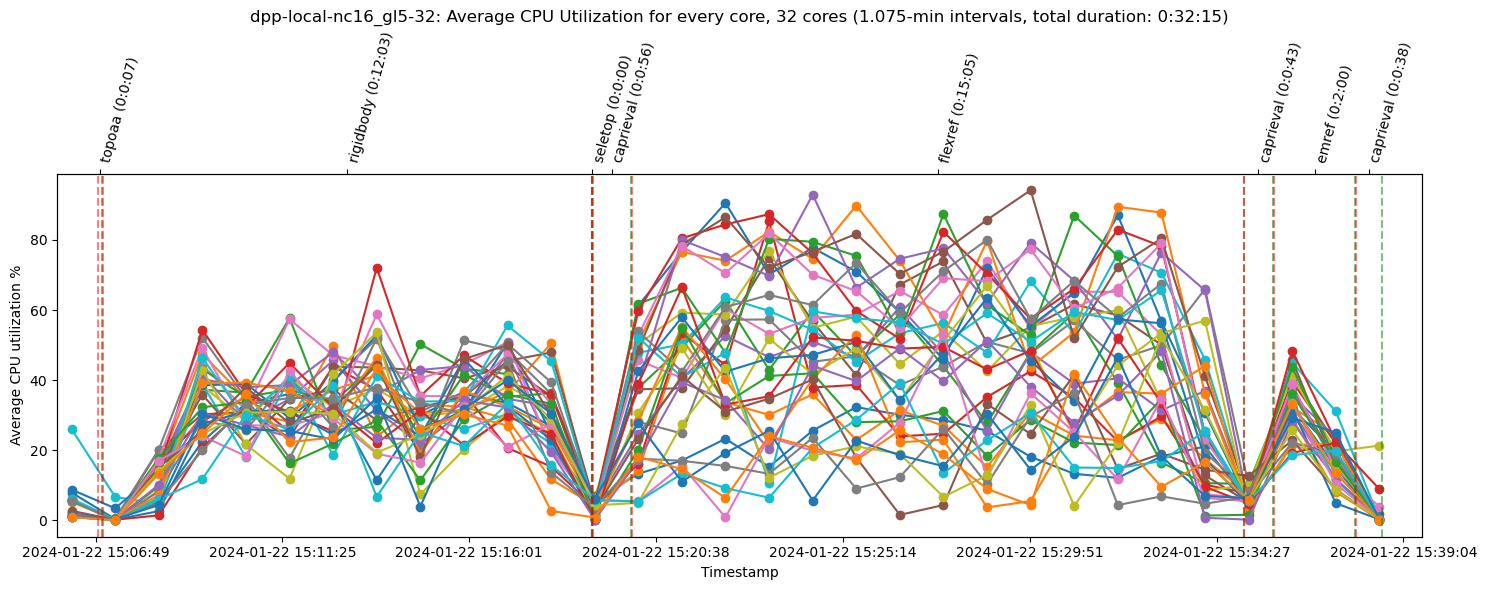

In [13]:
num_data_points = 30

field_name = '%user_%system'
idx_field_name = 'CPU'

cpu_util_df_every = cpu_util_df[cpu_util_df['CPU'] != 'all']

data_df = cpu_util_df_every
y_label = 'Average CPU utilization %'
title = 'Average CPU Utilization for every core'
png = "run_avg_cpu_util_every.png"

# Calculate the total duration in minutes
duration_delta = data_df['Timestamp'].max() - data_df['Timestamp'].min()
total_duration = duration_delta.total_seconds() / 60

# Calculate the frequency in minutes
freq = round(total_duration / num_data_points, 3)

# Calculate average CPU MHz values in intervals based on the frequency
avg_freq = data_df.groupby(pd.Grouper(key='Timestamp', freq=f'{freq}Min'))[field_name].mean().reset_index()

# Plot average CPU frequency with colored data points according to steps
fig, ax1 = plt.subplots(figsize=(15, 6))

# Loop over unique CPU values
for cpu in cpu_util_df_every[idx_field_name].unique():
    # Filter the DataFrame for the current CPU
    data_df = cpu_util_df_every[cpu_util_df_every[idx_field_name] == cpu]

    # Calculate average CPU MHz values in intervals based on the frequency
    avg_freq = data_df.groupby(pd.Grouper(key='Timestamp', freq=f'{freq}Min'))[field_name].mean().reset_index()

    ax1.plot(avg_freq['Timestamp'], avg_freq[field_name], marker='o', linestyle='-',
             label=f'CPU {cpu} {field_name}')

# Set the second x-axis for steps
ax2 = ax1.twiny()

# Set the labels on the top x-axis
ax2.set_xticks(midpoints)
ax2.set_xticklabels(labels, rotation=75, fontsize=10, ha="left")

# Format the x-axis date ticks
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M:%S'))

# Set custom x-axis and y-axis ticks for better visualization
x_ticks = pd.date_range(start=data_df['Timestamp'].min(), end=data_df['Timestamp'].max(), periods=num_ticks)
x_ticks = x_ticks.union([data_df['Timestamp'].min()])
ax1.set_xticks(x_ticks)

# Trim the right and left part of the graph
ax1.set_xlim(
    [steps_df['timestamp'].min() - pd.Timedelta(minutes=1), steps_df['timestamp'].max() + pd.Timedelta(minutes=1)])
ax2.set_xlim(ax1.get_xlim())

# Add vertical lines
for index, row in steps_df.iterrows():
    if row.event == 'start':
        step_start = row['timestamp']
        ax1.axvline(x=step_start, color='r', linestyle='--', alpha=.5)  # Add vertical line at the start of each step
    else:
        step_end = row['timestamp']
        ax1.axvline(x=step_end, color='g', linestyle='--', alpha=.5)  # Add vertical line at the end of each step

# Set labels and title
ax1.set_xlabel('Timestamp')
ax1.set_ylabel(y_label)
# ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
# ax1.legend()
n_cores = cpu_util_df_every[idx_field_name].unique().shape[0]
plt.title(
    f"{CONFIG}: {title}, {n_cores} cores ({freq}-min intervals, total duration: {format_timedelta(duration_delta)})")

# Show the plot
plt.tight_layout()
fig.savefig(png)

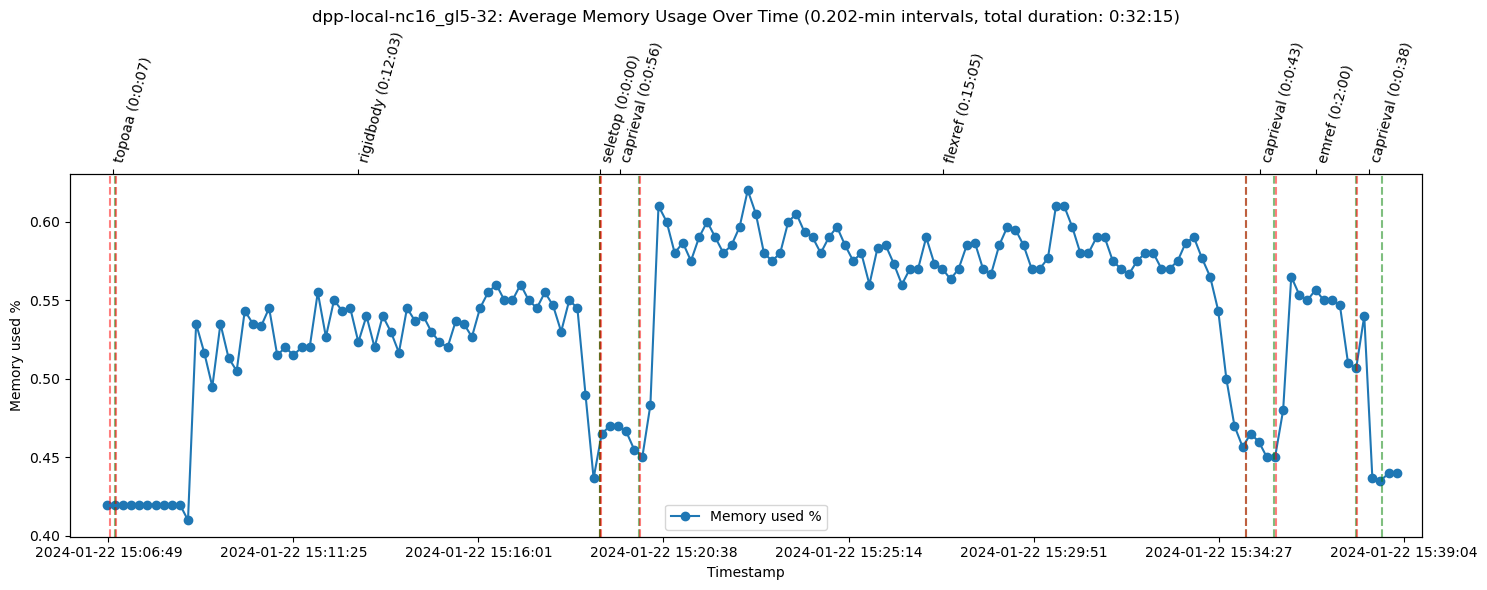

In [14]:
num_data_points = 160

mem_util_df, mem_util_merged_df = merge_with_steps(MEM_UTILIZATION_FILE)

field_name = '%memused'
data_df = mem_util_df
y_label = 'Memory used %'
title = 'Average Memory Usage Over Time'
png = "run_avg_mem_util.png"

# Calculate the total duration in minutes
duration_delta = data_df['Timestamp'].max() - data_df['Timestamp'].min()
total_duration = duration_delta.total_seconds() / 60

# Calculate the frequency in minutes
freq = round(total_duration / num_data_points, 3)

# Calculate average CPU MHz values in intervals based on the frequency
avg_freq = data_df.groupby(pd.Grouper(key='Timestamp', freq=f'{freq}Min'))[field_name].mean().reset_index()

# Plot average CPU frequency with colored data points according to steps
fig, ax1 = plt.subplots(figsize=(15, 6))

ax1.plot(avg_freq['Timestamp'], avg_freq[field_name], marker='o', linestyle='-',
         label=f'{y_label}')

# Set the second x-axis for steps
ax2 = ax1.twiny()

# Set the labels on the top x-axis
ax2.set_xticks(midpoints)
ax2.set_xticklabels(labels, rotation=75, fontsize=10, ha="left")

# Format the x-axis date ticks
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M:%S'))

# Set custom x-axis and y-axis ticks for better visualization
x_ticks = pd.date_range(start=data_df['Timestamp'].min(), end=data_df['Timestamp'].max(), periods=num_ticks)
x_ticks = x_ticks.union([data_df['Timestamp'].min()])
ax1.set_xticks(x_ticks)

# Trim the right and left part of the graph
ax1.set_xlim(
    [steps_df['timestamp'].min() - pd.Timedelta(minutes=1), steps_df['timestamp'].max() + pd.Timedelta(minutes=1)])
ax2.set_xlim(ax1.get_xlim())

# Add vertical lines
for index, row in steps_df.iterrows():
    if row.event == 'start':
        step_start = row['timestamp']
        ax1.axvline(x=step_start, color='r', linestyle='--', alpha=.5)  # Add vertical line at the start of each step
    else:
        step_end = row['timestamp']
        ax1.axvline(x=step_end, color='g', linestyle='--', alpha=.5)  # Add vertical line at the end of each step

# Set labels and title
ax1.set_xlabel('Timestamp')
ax1.set_ylabel(y_label)
ax1.legend()
plt.title(f"{CONFIG}: {title} ({freq}-min intervals, total duration: {format_timedelta(duration_delta)})")

# Show the plot
plt.tight_layout()
fig.savefig(png)

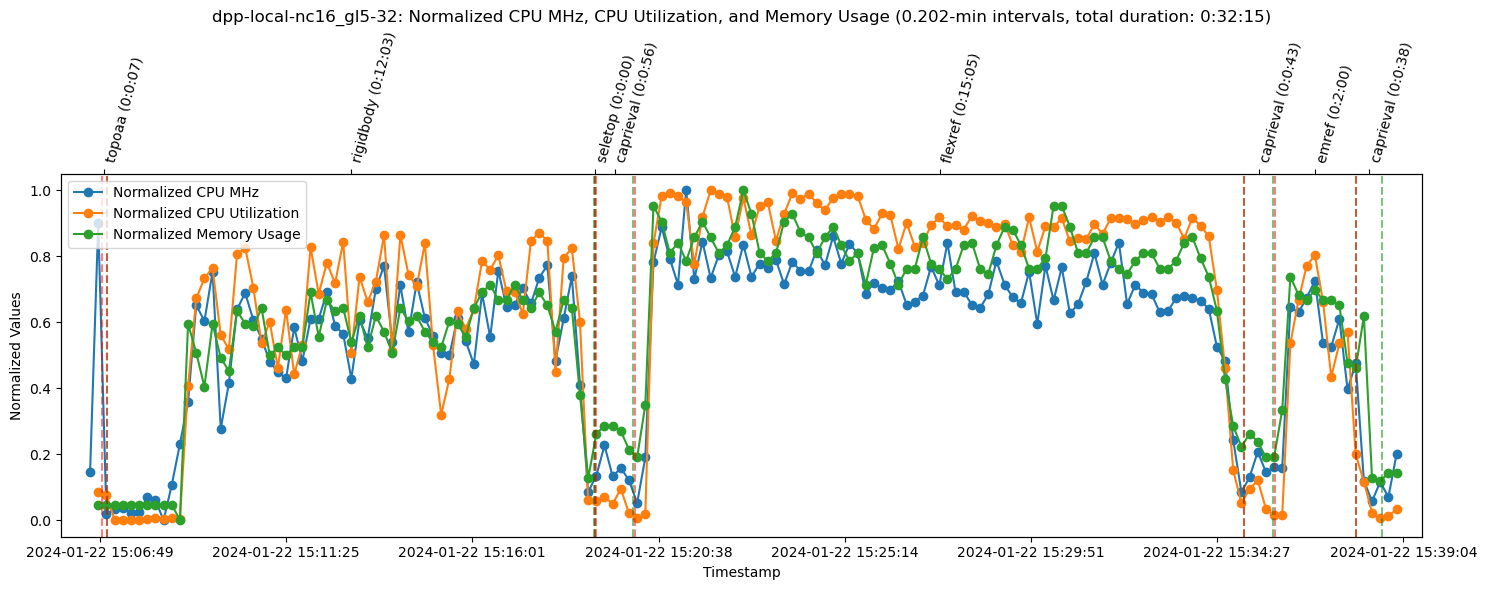

In [15]:
from sklearn.preprocessing import MinMaxScaler

num_data_points = 160

data_df = mem_util_df
y_label = 'Normalized Values'
title = 'Normalized CPU MHz, CPU Utilization, and Memory Usage'
png = "run_avg_normalized.png"

# Initialize the scaler
scaler = MinMaxScaler()

# Calculate the total duration in minutes
duration_delta = data_df['Timestamp'].max() - data_df['Timestamp'].min()
total_duration = duration_delta.total_seconds() / 60

# Calculate the frequency in minutes
freq = round(total_duration / num_data_points, 3)

# Calculate average values in intervals based on the frequency
avg_freq_cpu = cpu_freq_df.groupby(pd.Grouper(key='Timestamp', freq=f'{freq}Min'))['CPU MHz'].mean().reset_index()
avg_util_all = cpu_util_df_all.groupby(pd.Grouper(key='Timestamp', freq=f'{freq}Min'))[
    '%user_%system'].mean().reset_index()
avg_mem_util = mem_util_df.groupby(pd.Grouper(key='Timestamp', freq=f'{freq}Min'))['%memused'].mean().reset_index()

# Normalize the data
avg_freq_cpu['CPU MHz'] = scaler.fit_transform(avg_freq_cpu[['CPU MHz']])
avg_util_all['%user_%system'] = scaler.fit_transform(avg_util_all[['%user_%system']])
avg_mem_util['%memused'] = scaler.fit_transform(avg_mem_util[['%memused']])

# Plot average values with colored data points according to steps
fig, ax1 = plt.subplots(figsize=(15, 6))

ax1.plot(avg_freq_cpu['Timestamp'], avg_freq_cpu['CPU MHz'], marker='o', linestyle='-',
         label=f'Normalized CPU MHz')
ax1.plot(avg_util_all['Timestamp'], avg_util_all['%user_%system'], marker='o', linestyle='-',
         label=f'Normalized CPU Utilization')
ax1.plot(avg_mem_util['Timestamp'], avg_mem_util['%memused'], marker='o', linestyle='-',
         label=f'Normalized Memory Usage')

# Set the second x-axis for steps
ax2 = ax1.twiny()

# Set the labels on the top x-axis
ax2.set_xticks(midpoints)
ax2.set_xticklabels(labels, rotation=75, fontsize=10, ha="left")

# Format the x-axis date ticks
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M:%S'))

# Set custom x-axis and y-axis ticks for better visualization
x_ticks = pd.date_range(start=data_df['Timestamp'].min(), end=data_df['Timestamp'].max(), periods=num_ticks)
x_ticks = x_ticks.union([data_df['Timestamp'].min()])
ax1.set_xticks(x_ticks)

# Trim the right and left part of the graph
ax1.set_xlim(
    [steps_df['timestamp'].min() - pd.Timedelta(minutes=1), steps_df['timestamp'].max() + pd.Timedelta(minutes=1)])
ax2.set_xlim(ax1.get_xlim())

# Add vertical lines
for index, row in steps_df.iterrows():
    if row.event == 'start':
        step_start = row['timestamp']
        ax1.axvline(x=step_start, color='r', linestyle='--', alpha=.5)  # Add vertical line at the start of each step
    else:
        step_end = row['timestamp']
        ax1.axvline(x=step_end, color='g', linestyle='--', alpha=.5)  # Add vertical line at the end of each step

# Set labels and title
ax1.set_xlabel('Timestamp')
ax1.set_ylabel(y_label)
ax1.legend()
plt.title(f"{CONFIG}: {title} ({freq}-min intervals, total duration: {format_timedelta(duration_delta)})")

# Show the plot
plt.tight_layout()
fig.savefig(png)